# import

In [1]:
# importing modules

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import pickle
import joblib as jl
import os
import gc
import seaborn as sb

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.test.gpu_device_name()
tf.device('/GPU:0')

import multiprocessing
cores=multiprocessing.cpu_count()-5

import optuna
from optuna.samplers import TPESampler

2024-12-16 21:59:25.259377: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-16 21:59:32.034157: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-12-16 21:59:33.113617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-16 21:59:33.113872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 Ti Laptop GPU computeCapability: 8.6
coreClock: 1.035GHz coreCount: 46 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 357.69GiB/s
2024-12-16 21:59:33.113961: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-16 21:59:33.141505: I tensorflo

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
num_classes = 19 #0 - 18
np.random.seed(441) #setting seed
img_rows, img_cols = 28, 58 #image dimensions

# the data, split between train and test sets
(x_train_in, y_train_in), (x_test_in, y_test_in) = mnist.load_data()

x_train_in = x_train_in.astype('float32')
x_train_in /= 255.0
x_train_in = x_train_in.reshape(x_train_in.shape[0], -1)

x_test_in = x_test_in.astype('float32')
x_test_in /= 255.0
x_test_in = x_test_in.reshape(x_test_in.shape[0], -1)

In [4]:
def jl_pairs(i, j, pairs_per_combination, X, Y):
    idxl1 = np.where(Y == i)[0]
    idxl2 = np.where(Y == j)[0]

    imgs = []
    labels = []

    for k in range(pairs_per_combination):
        idx1 = np.random.choice(idxl1)
        idx2 = np.random.choice(idxl2)
        combined_img = np.hstack((X[idx1], X[idx2]))
        combined_label = i+j
        imgs.append(combined_img)
        labels.append(combined_label)

    return imgs, labels

def jl_dataset(X, Y, output=100000, n_jobs=cores):

    pairs_per_combination = int(output)//100
    results = jl.Parallel(n_jobs=n_jobs)(jl.delayed(jl_pairs)(i, j, pairs_per_combination, X, Y) for i in range(10) for j in range(10))
    
    imgs = []
    labels = []

    for ri, rl in results:
        imgs.extend(ri)
        labels.extend(rl)

    shuffle_idx = np.random.permutation((len(imgs)))
    imgs = np.array(imgs)[shuffle_idx]
    labels = np.array(labels)[shuffle_idx]
    
    return imgs, labels

In [5]:
def score_model(model, x_test, y_test, name):
    predictions = model.predict(x_test)
    score = model.score(x_test, y_test)
    accuracy = accuracy_score(y_true=y_test, y_pred=predictions)
    classification = classification_report(y_true=y_test, y_pred=predictions)
    confusion = confusion_matrix(y_true=y_test, y_pred=predictions)
    jl.dump(confusion, f"confusion_{name}.pkl")
    jl.dump(model, f"model_{name}.pkl")
    jl.dump(predictions, f"predictions_{name}.pkl")
    jl.dump(score, f"score_{name}.pkl")
    jl.dump(accuracy, f"accuracy_{name}.pkl")
    jl.dump(classification, f"classification_{name}.pkl")
    print(f"Score: {score}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification accuracy:\n{classification}")
    fig, ax = plt.subplots(figsize=(15, 8))
    ax = sb.heatmap(confusion, annot=True, fmt='g')
    ax.set_xlabel("Class")
    ax.set_ylabel("Class")
    ax.set_title(f"Confusion Matrix for {name}", fontsize=20)
    plt.savefig(f"confusion_{name}.png")
    plt.show()

In [6]:
def get_data(output=100000, train_ratio=0.8, split=True):

    np.random.seed(442)
    train_shuffle_idx = np.random.permutation(len(x_train_in))
    x_train = x_train_in[train_shuffle_idx]
    y_train = y_train_in[train_shuffle_idx]

    test_shuffle_idx = np.random.permutation(len(x_test_in))
    x_test = x_test_in[test_shuffle_idx]
    y_test = y_test_in[test_shuffle_idx]
    
    test_ratio = round(1 - train_ratio, 2)

    x_train, y_train = jl_dataset(x_train, y_train, output=int(output*train_ratio))
    
    x_test, y_test = jl_dataset(x_test, y_test, output=int(output*test_ratio))

    # y_train = to_categorical(y_train, num_classes)
    # y_test = to_categorical(y_test, num_classes)

    if split:        
        return x_train, y_train, x_test, y_test
    else:
        X = np.concatenate([x_train, x_test])
        Y = np.concatenate([y_train, y_test])
        shuffle_idx = np.random.permutation(len(X))
        X = X[shuffle_idx]
        Y = Y[shuffle_idx]
        return X, Y

# SVM

In [13]:
X, Y = get_data(output=10000, split=False)

In [15]:
def objective(trial):
    gamma = trial.suggest_float('gamma', 0.01, 6000, log=True)
    c = trial.suggest_float('c', 0.01, 1000, log=True)
    # kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid'])
    degree = trial.suggest_int('degree',3, 6)

    svm = SVC(
        kernel='poly', 
        gamma=gamma, 
        C=c, 
        degree=degree,
        decision_function_shape='ovr',
        random_state=441
          )
    
    cv = StratifiedKFold(n_splits=5, random_state=441, shuffle=True)
    score = cross_val_score(svm, X, Y, cv=cv, scoring='accuracy')
    return np.mean(score)

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=20, show_progress_bar=True)

with open("best_svm_model.pkl", "wb") as f:
    pickle.dump(study, f)

[I 2024-12-11 16:22:13,925] A new study created in memory with name: no-name-4b4510b0-f438-46cb-b241-9293ff133cbc


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-12-11 16:27:42,077] Trial 0 finished with value: 0.477 and parameters: {'gamma': 0.20011105447282287, 'c': 0.8197266722694794, 'degree': 6}. Best is trial 0 with value: 0.477.
[I 2024-12-11 16:32:53,384] Trial 1 finished with value: 0.477 and parameters: {'gamma': 87.53323227879775, 'c': 500.23459592029536, 'degree': 6}. Best is trial 0 with value: 0.477.
[I 2024-12-11 16:37:02,142] Trial 2 finished with value: 0.5714 and parameters: {'gamma': 495.1266974683538, 'c': 0.10176108820198808, 'degree': 4}. Best is trial 2 with value: 0.5714.
[I 2024-12-11 16:41:26,247] Trial 3 finished with value: 0.5909000000000001 and parameters: {'gamma': 2546.7561620454876, 'c': 0.6661518751015605, 'degree': 3}. Best is trial 3 with value: 0.5909000000000001.
[I 2024-12-11 16:46:25,847] Trial 4 finished with value: 0.477 and parameters: {'gamma': 3788.753841525434, 'c': 0.022904137051989005, 'degree': 6}. Best is trial 3 with value: 0.5909000000000001.
[I 2024-12-11 16:50:19,569] Trial 5 finishe

In [8]:
with open("best_svm_model.pkl", "rb") as f:
    svm_study = pickle.load(f)
    
print('Best trial:')
print(f' Value: {svm_study.best_trial.value}')
print(' Params: ')
for key, value in svm_study.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
 Value: 0.6
 Params: 
    gamma: 21.768741718394928
    c: 1.6140097971440113
    degree: 3


In [10]:
x_train, y_train, x_test, y_test = get_data(output=80000, split=True)

svm = SVC(
        kernel='poly', 
        gamma=svm_study.best_trial.params['gamma'], 
        C=svm_study.best_trial.params['c'], 
        degree=svm_study.best_trial.params['degree'],
        decision_function_shape='ovr',
        random_state=441
          )

svm_clf = svm.fit(x_train, y_train)

In [11]:
with open("svm_fitted_model.pkl", "wb") as f:
    pickle.dump(svm_clf, f)

Score: 0.8045
Accuracy: 0.8045
Classification accuracy:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       160
           1       0.89      0.99      0.93       320
           2       0.87      0.89      0.88       480
           3       0.85      0.87      0.86       640
           4       0.86      0.86      0.86       800
           5       0.82      0.85      0.83       960
           6       0.82      0.82      0.82      1120
           7       0.80      0.80      0.80      1280
           8       0.77      0.79      0.78      1440
           9       0.80      0.81      0.80      1600
          10       0.77      0.78      0.78      1440
          11       0.76      0.72      0.74      1280
          12       0.79      0.78      0.79      1120
          13       0.79      0.78      0.78       960
          14       0.81      0.77      0.79       800
          15       0.82      0.76      0.79       640
          16       0.81  

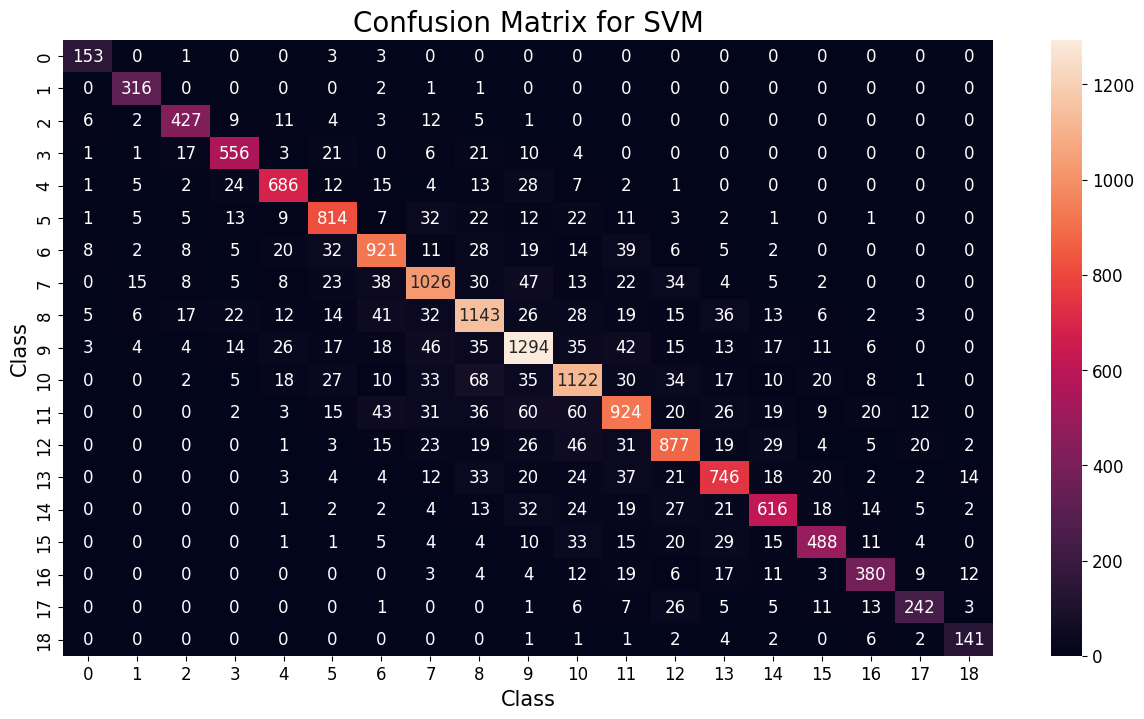

In [13]:
with open("svm_fitted_model.pkl", "rb") as f:
    svm_clf = pickle.load(f)

score_model(svm_clf, x_test, y_test, "SVM")

# Random Forest

In [7]:
x_train, y_train, x_test, y_test = get_data(output=80000, train_ratio=0.8, split=True)

In [8]:
def forest_objective(trial):
    depth = trial.suggest_int('depth', 500, 1000)
    n_estimators = trial.suggest_int('n_estimators', 10, 250)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    forest = RandomForestClassifier(max_depth=depth, n_jobs=cores, n_estimators=n_estimators, criterion=criterion, max_features=max_features)
    forest.fit(x_train, y_train)
    score = forest.score(x_test, y_test)
    
    return score

forest_study = optuna.create_study(direction='maximize')

forest_study.optimize(forest_objective, n_trials=50, show_progress_bar=True)

[I 2024-12-11 14:20:12,219] A new study created in memory with name: no-name-b71bb9e6-cf2f-475b-b863-b32fb6c09bb1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-12-11 14:20:56,895] Trial 0 finished with value: 0.78225 and parameters: {'depth': 989, 'n_estimators': 229, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 0 with value: 0.78225.
[I 2024-12-11 14:21:02,632] Trial 1 finished with value: 0.6396875 and parameters: {'depth': 538, 'n_estimators': 19, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 0 with value: 0.78225.
[I 2024-12-11 14:21:25,768] Trial 2 finished with value: 0.771625 and parameters: {'depth': 510, 'n_estimators': 145, 'criterion': 'gini', 'max_features': 'sqrt'}. Best is trial 0 with value: 0.78225.
[I 2024-12-11 14:21:35,222] Trial 3 finished with value: 0.7079375 and parameters: {'depth': 738, 'n_estimators': 38, 'criterion': 'log_loss', 'max_features': 'sqrt'}. Best is trial 0 with value: 0.78225.
[I 2024-12-11 14:21:46,639] Trial 4 finished with value: 0.742875 and parameters: {'depth': 583, 'n_estimators': 204, 'criterion': 'gini', 'max_features': 'log2'}. Best is trial 0 with va

In [9]:
with open("best_forest_model.pkl", "wb") as f:
    pickle.dump(forest_study, f)

In [8]:
with open("best_forest_model.pkl", "rb") as f:
    forest_study = pickle.load(f)

print('Best trial:')
print(f' Value: {forest_study.best_trial.value}')
print(' Params: ')
for key, value in forest_study.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
 Value: 0.7875625
 Params: 
    depth: 591
    n_estimators: 249
    criterion: gini
    max_features: sqrt


In [9]:
forest = RandomForestClassifier(max_depth=forest_study.best_trial.params['depth'], 
                                n_jobs=cores, 
                                n_estimators=forest_study.best_trial.params['n_estimators'], 
                                criterion=forest_study.best_trial.params['criterion'], 
                                max_features=forest_study.best_trial.params['max_features'])

forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=591, n_estimators=249, n_jobs=15)

Score: 0.7886875
Accuracy: 0.7886875
Classification accuracy:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       160
           1       0.91      0.97      0.94       320
           2       0.91      0.88      0.89       480
           3       0.87      0.84      0.86       640
           4       0.85      0.78      0.82       800
           5       0.83      0.81      0.82       960
           6       0.81      0.82      0.82      1120
           7       0.83      0.79      0.81      1280
           8       0.74      0.82      0.78      1440
           9       0.74      0.84      0.79      1600
          10       0.75      0.77      0.76      1440
          11       0.73      0.78      0.75      1280
          12       0.71      0.79      0.75      1120
          13       0.75      0.74      0.74       960
          14       0.86      0.67      0.75       800
          15       0.85      0.72      0.78       640
          16       

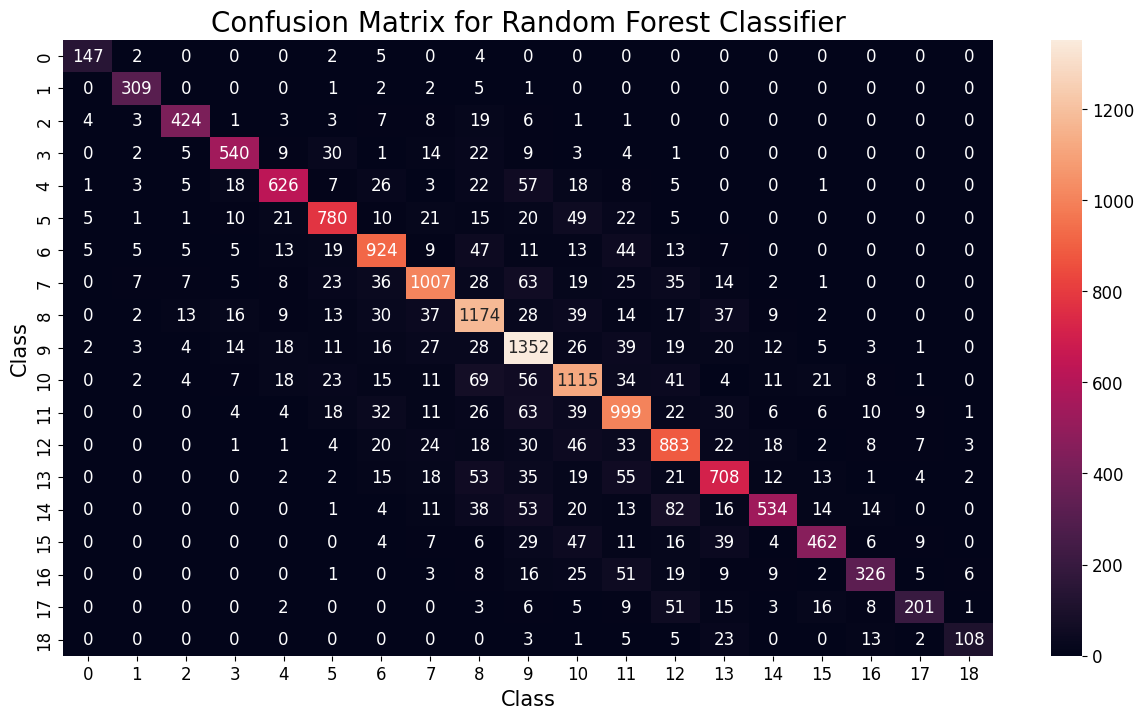

In [10]:
score_model(forest, x_test, y_test, "Random Forest Classifier")

# Adaboost

In [7]:
x_train, y_train, x_test, y_test = get_data(output=50000, train_ratio=0.8, split=True)

In [8]:
def adaboost_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 100)

    adaboost = AdaBoostClassifier(n_estimators=n_estimators)
    adaboost.fit(x_train, y_train)
    score = adaboost.score(x_test, y_test)
    
    return score

adaboost_study = optuna.create_study(direction='maximize')

adaboost_study.optimize(adaboost_objective, n_trials=10, show_progress_bar=True)

with open("best_adaboost_model.pkl", "wb") as f:
    pickle.dump(adaboost_study, f)

[I 2024-12-11 15:21:03,909] A new study created in memory with name: no-name-08e14f3e-f645-4862-be43-d4bb624e7c07


  0%|          | 0/10 [00:00<?, ?it/s]

/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-11 15:23:21,997] Trial 0 finished with value: 0.1336 and parameters: {'n_estimators': 83}. Best is trial 0 with value: 0.1336.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-11 15:25:32,045] Trial 1 finished with value: 0.1345 and parameters: {'n_estimators': 78}. Best is trial 1 with value: 0.1345.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-11 15:27:11,036] Trial 2 finished with value: 0.1357 and parameters: {'n_estimators': 59}. Best is trial 2 with value: 0.1357.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-11 15:29:19,334] Trial 3 finished with value: 0.1345 and parameters: {'n_estimators': 78}. Best is trial 2 with value: 0.1357.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-11 15:31:56,427] Trial 4 finished with value: 0.1299 and parameters: {'n_estimators': 96}. Best is trial 2 with value: 0.1357.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-11 15:34:08,654] Trial 5 finished with value: 0.1336 and parameters: {'n_estimators': 82}. Best is trial 2 with value: 0.1357.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-11 15:36:47,470] Trial 6 finished with value: 0.1297 and parameters: {'n_estimators': 97}. Best is trial 2 with value: 0.1357.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-11 15:38:28,345] Trial 7 finished with value: 0.1335 and parameters: {'n_estimators': 64}. Best is trial 2 with value: 0.1357.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-11 15:40:19,813] Trial 8 finished with value: 0.1351 and parameters: {'n_estimators': 69}. Best is trial 2 with value: 0.1357.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-11 15:41:47,161] Trial 9 finished with value: 0.1385 and parameters: {'n_estimators': 53}. Best is trial 9 with value: 0.1385.


In [9]:
with open("best_adaboost_model.pkl", "rb") as f:
    adaboost_study = pickle.load(f)

print('Best trial:')
print(f' Value: {adaboost_study.best_trial.value}')
print(' Params: ')
for key, value in adaboost_study.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
 Value: 0.1385
 Params: 
    n_estimators: 53


In [10]:
x_train, y_train, x_test, y_test = get_data(output=90000, train_ratio=0.8, split=True)

In [ ]:
adaboost = AdaBoostClassifier(n_estimators=adaboost_study.best_trial.params['n_estimators'])

adaboost.fit(x_train, y_train)

with open("adaboost_fitted_model.pkl", "wb") as f:
  pickle.dump(adaboost, f)

NameError: name 'AdaBoostClassifier' is not defined

In [ ]:
with open("adaboost_fitted_model.pkl", "rb") as f:
    adaboost = pickle.load(f)
score_model(adaboost, x_test, y_test, "AdaBoost Classifier")